In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
# Subimos un nivel para estar en la carpeta nuevo"Nuevo"
os.chdir("../")  

sys.path.append(os.getcwd())

In [4]:
import os
print(os.getcwd())


e:\Máster Bioinformática\TFM\Nuevo


In [100]:
# Cargar el dataset
dataset_path = "./data/processed/dataset_final_small.csv"  
data = pd.read_csv(dataset_path)

# Distribución de pChEMBL

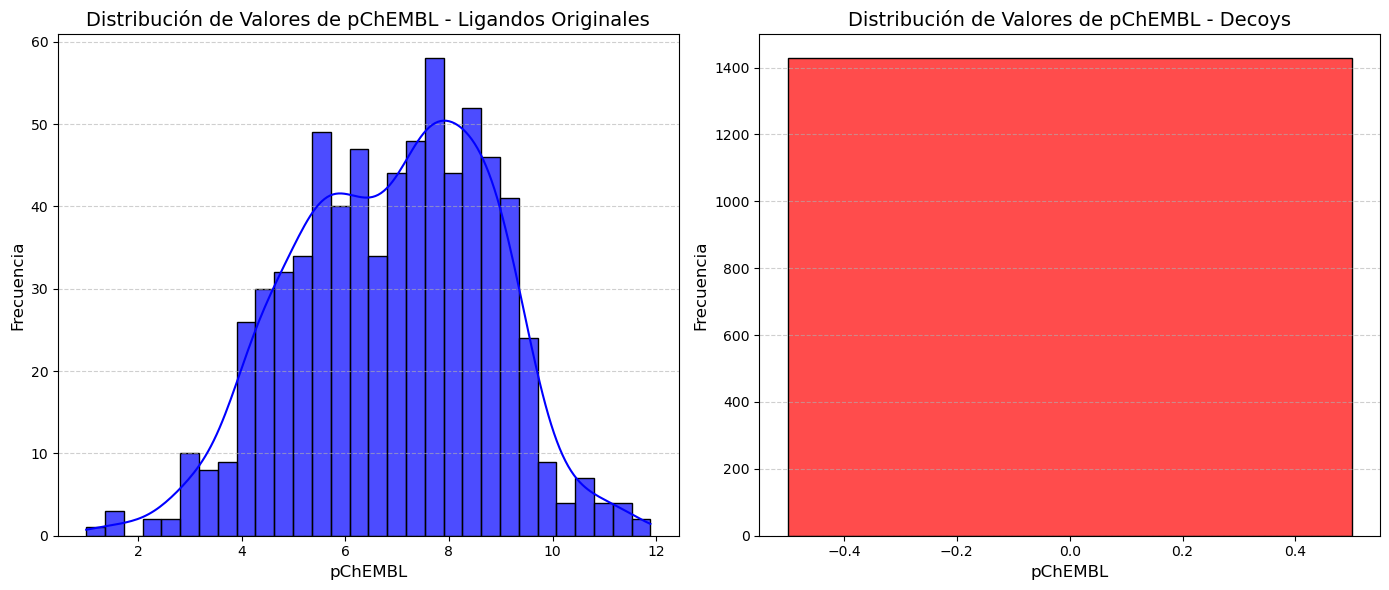

In [6]:
# Separar ligandos originales y decoys
ligandos_originales = data[data['pChEMBL'] != 0]  # Valores diferentes de 0 son ligandos originales
decoys = data[data['pChEMBL'] == 0]  # Valores 0 son decoys

# Configuración del tamaño de la figura
plt.figure(figsize=(14, 6))

# Subplot para los ligandos originales
plt.subplot(1, 2, 1)
sns.histplot(ligandos_originales['pChEMBL'], bins=30, kde=True, color="blue", alpha=0.7)
plt.title("Distribución de Valores de pChEMBL - Ligandos Originales", fontsize=14)
plt.xlabel("pChEMBL", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Subplot para los decoys
plt.subplot(1, 2, 2)
sns.histplot(decoys['pChEMBL'], bins=1, kde=False, color="red", alpha=0.7)
plt.title("Distribución de Valores de pChEMBL - Decoys", fontsize=14)
plt.xlabel("pChEMBL", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [7]:
# Resumen estadístico Ligandos Originales
summary = ligandos_originales['pChEMBL'].describe()
print(summary)

count    714.000000
mean       6.907889
std        1.879099
min        1.000000
25%        5.492500
50%        7.080000
75%        8.369500
max       11.890000
Name: pChEMBL, dtype: float64


In [8]:
# Resumen estadístico Decoys
summary = decoys['pChEMBL'].describe()
print(summary)

count    1428.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: pChEMBL, dtype: float64


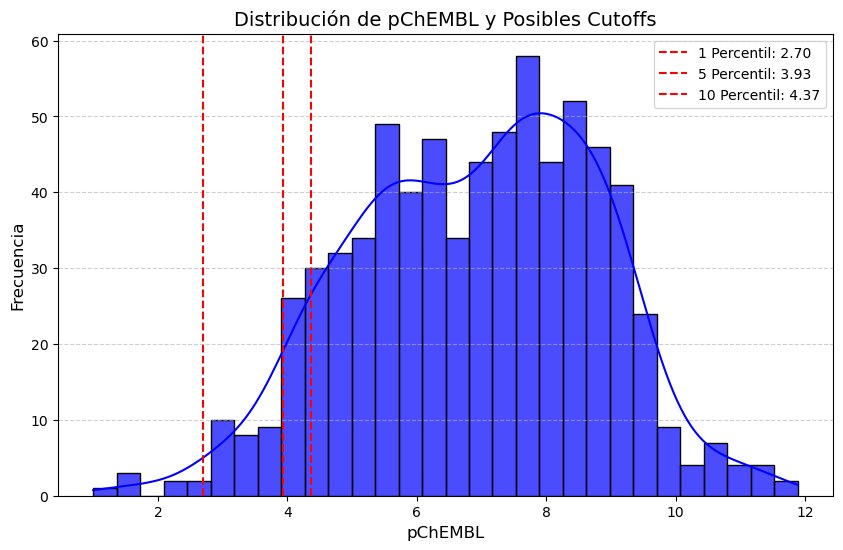

1 Percentil: 2.70
5 Percentil: 3.93
10 Percentil: 4.37


In [9]:
# Calcular percentiles relevantes
percentiles = [1, 5, 10]
cutoff_values = np.percentile(ligandos_originales['pChEMBL'], percentiles)

# Mostrar los percentiles en un gráfico
plt.figure(figsize=(10, 6))
sns.histplot(ligandos_originales['pChEMBL'], bins=30, kde=True, color="blue", alpha=0.7)
for percentile, cutoff in zip(percentiles, cutoff_values):
    plt.axvline(cutoff, color="red", linestyle="--", label=f"{percentile} Percentil: {cutoff:.2f}")

plt.title("Distribución de pChEMBL y Posibles Cutoffs", fontsize=14)
plt.xlabel("pChEMBL", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Mostrar los valores calculados
for percentile, cutoff in zip(percentiles, cutoff_values):
    print(f"{percentile} Percentil: {cutoff:.2f}")

# Distribución Grupos Funcionales

In [87]:
def calcular_estadisticas_fgs(fgs):
    # Utilizar la columna 'mol_id' como identificador de molécula
    mol_col = fgs["mol_id"]
    # Contar el número de moléculas únicas
    n_mols = len(mol_col.unique())
    # Expandir las listas de fragmentos funcionales
    all_fgs = [fg for row in fgs['pseudo_smiles'] for fg in row]
    # Crear un contador de FGs para contar ocurrencias
    fg_counter = Counter(all_fgs)
    # Contar el número total de fragmentos
    n_total_fgs = len(all_fgs)
    # Calcular el promedio de FGs por molécula
    fg_per_mol = n_total_fgs / n_mols

    # Calcular fragmentos binarios (presencia/ausencia de FGs en cada molécula)
    binary_fg = fgs['pseudo_smiles'].apply(lambda row: len(set(row))).sum()
    fg_bin_per_mol = binary_fg / n_mols

    # Calcular el número de FGs únicos en todo el dataset
    unique_fgs = len(fg_counter)
    unique_fg_per_mol = unique_fgs / n_mols

    # Crear una tabla con las estadísticas calculadas
    stats_table1 = {
        'n': [n_mols],
        'Total FGs': [n_total_fgs],
        'FGs por mol': [fg_per_mol],
        'FGs binarios': [binary_fg],
        'FGs binarios por mol': [fg_bin_per_mol],
        'FGs únicos': [unique_fgs],
        'FGs únicos por mol': [unique_fg_per_mol]
    }

    # Convertir a DataFrame para facilitar la visualización y uso posterior
    stats_table1_df = pd.DataFrame(stats_table1)

    return stats_table1_df

def calcular_estadisticas_aromaticos_heteroatomos(fgs):
    # Definir una función para identificar si un FG es aromático
    def is_aromatic(smiles):
        return 'ar' in smiles

    # Definir una función para identificar si un FG contiene heteroátomos
    def is_heteroatom(smiles):
        heteroatoms = ['O', 'N', 'S', 'P', 'F', 'Cl', 'Br', 'I']
        return any(atom in smiles for atom in heteroatoms)

    # Expandir todas las listas de fragmentos funcionales
    all_fgs = [fg for row in fgs['pseudo_smiles'] for fg in row]

    # Calcular fragmentos únicos y binarios
    unique_aromatic_fgs = fgs['pseudo_smiles'].apply(lambda row: len(set(fg for fg in row if is_aromatic(fg)))).sum()
    unique_heteroatom_fgs = fgs['pseudo_smiles'].apply(lambda row: len(set(fg for fg in row if is_heteroatom(fg)))).sum()

    binary_aromatic = fgs['pseudo_smiles'].apply(lambda row: any(is_aromatic(fg) for fg in row)).sum()
    binary_heteroatom = fgs['pseudo_smiles'].apply(lambda row: any(is_heteroatom(fg) for fg in row)).sum()

    # Número total de moléculas
    n_mols = len(fgs['mol_id'].unique())

    # Calcular valores por molécula
    ar_fgs_bin_per_mol = binary_aromatic / n_mols
    ar_fgs_un_per_mol = unique_aromatic_fgs / n_mols

    het_fgs_bin_per_mol = binary_heteroatom / n_mols
    het_fgs_un_per_mol = unique_heteroatom_fgs / n_mols

    # Crear tabla de estadísticas para los fragmentos aromáticos y con heteroátomos
    stats_table2 = {
        'Ar FGs (bin) / mol': [ar_fgs_bin_per_mol],
        '# Ar FGs (un)': [unique_aromatic_fgs],
        'Ar FGs (un) / mol': [ar_fgs_un_per_mol],
        'Het FGs (bin) / mol': [het_fgs_bin_per_mol],
        '# Het FGs (un)': [unique_heteroatom_fgs],
        'Het FGs (un) / mol': [het_fgs_un_per_mol]
    }

    stats_table2_df = pd.DataFrame(stats_table2)

    return stats_table2_df

def calcular_estadisticas_heteroatomos(fgs):
    # Funciones para identificar los FGs que contienen O, N, S, P y halógenos
    def contains_oxygen(fg): return 'O' in fg
    def contains_nitrogen(fg): return 'N' in fg
    def contains_sulfur(fg): return 'S' in fg
    def contains_phosphorus(fg): return 'P' in fg
    def contains_halogen(fg): return any(x in fg for x in ['F', 'Cl', 'Br', 'I'])

    # Expandir todas las listas de fragmentos funcionales
    all_fgs = [fg for row in fgs['pseudo_smiles'] for fg in row]

    # Contar fragmentos que contienen cada tipo de heteroátomo
    o_count = sum(contains_oxygen(fg) for fg in all_fgs)
    n_count = sum(contains_nitrogen(fg) for fg in all_fgs)
    s_count = sum(contains_sulfur(fg) for fg in all_fgs)
    p_count = sum(contains_phosphorus(fg) for fg in all_fgs)
    x_count = sum(contains_halogen(fg) for fg in all_fgs)

    # Calcular fragmentos binarios (presencia/ausencia por molécula)
    binary_o = fgs['pseudo_smiles'].apply(lambda row: any(contains_oxygen(fg) for fg in row)).sum()
    binary_n = fgs['pseudo_smiles'].apply(lambda row: any(contains_nitrogen(fg) for fg in row)).sum()
    binary_s = fgs['pseudo_smiles'].apply(lambda row: any(contains_sulfur(fg) for fg in row)).sum()
    binary_p = fgs['pseudo_smiles'].apply(lambda row: any(contains_phosphorus(fg) for fg in row)).sum()
    binary_x = fgs['pseudo_smiles'].apply(lambda row: any(contains_halogen(fg) for fg in row)).sum()

    # Número total de moléculas
    n_mols = len(fgs['mol_id'].unique())

    # Calcular promedios por molécula
    o_fgs_bin_per_mol = binary_o / n_mols
    n_fgs_bin_per_mol = binary_n / n_mols
    s_fgs_bin_per_mol = binary_s / n_mols
    p_fgs_bin_per_mol = binary_p / n_mols
    x_fgs_bin_per_mol = binary_x / n_mols

    # Crear la tabla de estadísticas
    stats_table3 = pd.DataFrame({
        'O FGs (bin) / mol': [o_fgs_bin_per_mol],
        'N FGs (bin) / mol': [n_fgs_bin_per_mol],
        'S FGs (bin) / mol': [s_fgs_bin_per_mol],
        'P FGs (bin) / mol': [p_fgs_bin_per_mol],
        'X FGs (bin) / mol': [x_fgs_bin_per_mol],
        'Total O FGs': [o_count],
        'Total N FGs': [n_count],
        'Total S FGs': [s_count],
        'Total P FGs': [p_count],
        'Total X FGs': [x_count]
    })

    return stats_table3

def visualizar_coocurrencia_top_20_fgs(fgs, ax):
    """
    Genera un heatmap de la matriz de co-ocurrencia de los top 20 fragmentos funcionales en el subplot dado.
    """
    # Expandir las listas de fragmentos funcionales
    all_fgs = [fg for row in fgs['pseudo_smiles'] for fg in row]
    fg_counter = Counter(all_fgs)

    # Obtener los 20 fragmentos funcionales más comunes
    top_20_fgs = [fg for fg, _ in fg_counter.most_common(20)]

    # Crear una matriz binaria de presencia/ausencia
    fg_presence = pd.DataFrame([
        [1 if fg in row else 0 for fg in top_20_fgs]
        for row in fgs['pseudo_smiles']
    ], columns=top_20_fgs)

    # Calcular co-ocurrencias
    co_occurrence_matrix = np.dot(fg_presence.T, fg_presence)

    # Convertir la matriz a DataFrame para etiquetar correctamente los fragmentos funcionales
    co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=top_20_fgs, columns=top_20_fgs)

    # Convertir a tipo flotante para manejar NaN
    co_occurrence_df = co_occurrence_df.astype(float)

    # Eliminar la diagonal (asignarla a NaN para que no se muestre)
    np.fill_diagonal(co_occurrence_df.values, np.nan)

    # Visualización en el eje proporcionado
    sns.heatmap(
        co_occurrence_df,
        cmap='YlGnBu',
        annot=False,  # No mostrar números dentro de los cuadrados
        cbar=True,    # Mostrar barra de colores
        square=True,  # Mantener las celdas cuadradas
        ax=ax         # Dibujar en el subplot especificado
    )
    ax.set_title("Matriz de Co-ocurrencia de los Top 20 Grupos Funcionales")
    ax.set_xlabel("Grupos Funcionales")
    ax.set_ylabel("Grupos Funcionales")
    ax.tick_params(axis='x', rotation=90)


def plot_top_20_fgs(fgs, ax):
    """
    Genera el gráfico de barras de los top 20 fragmentos funcionales en el subplot dado.
    """
    # Expandir las listas de fragmentos funcionales
    all_fgs = [fg for row in fgs['pseudo_smiles'] for fg in row]
    # Crear un contador de FGs para contar ocurrencias
    fg_counter = Counter(all_fgs)
    # Obtener los 20 fragmentos funcionales más comunes
    top_20_fgs = fg_counter.most_common(20)
    fg_names, fg_counts = zip(*top_20_fgs)  # Desempaquetar nombres y conteos

    # Crear el gráfico de barras en el eje proporcionado
    bars = ax.bar(fg_names, fg_counts)
    ax.set_xlabel('Fragmentos Funcionales (FG)')
    ax.set_ylabel('Número de Apariciones')
    ax.set_title('Distribución de los 20 Principales FGs')
    ax.tick_params(axis='x', rotation=90)

    # Añadir etiquetas con el conteo sobre cada barra
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')


In [92]:
def combinar_graficas_top_fgs(fgs, titulo):
    """
    Combina el gráfico de los top 20 fragmentos funcionales y
    la matriz de co-ocurrencia en una sola imagen con un título general personalizado.
    
    Parameters:
    - fgs: DataFrame con los datos de los fragmentos funcionales.
    - titulo: Título general para la figura.
    """
    # Crear la figura con subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Una fila, dos columnas

    # Subplot 1: Gráfico de barras de los top 20 fragmentos funcionales
    plot_top_20_fgs(fgs, axes[0])

    # Subplot 2: Matriz de co-ocurrencia
    visualizar_coocurrencia_top_20_fgs(fgs, axes[1])

    # Añadir un título general para toda la figura
    fig.suptitle(titulo, fontsize=16, fontweight='bold')

    # Ajustar diseño
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reservar espacio para el título general
    plt.show()



## Resultados con los Ligandos Originales

In [11]:
# Cargar el archivo top_100_groups.csv
top_100_groups = pd.read_csv('./data/processed/top_100_fgs_ligandos_originales.csv')

# Asegurarte de que el archivo de top 100 contiene una columna pseudo_smiles
top_smiles_list = top_100_groups['pseudo_smiles'].tolist()

# Función para convertir un vector n-hot a pseudo-smiles
def n_hot_to_pseudo_smiles(n_hot_vector, top_smiles):
    # Crear una lista para almacenar los pseudo-smiles correspondientes
    pseudo_smiles = []
    for index, count in enumerate(n_hot_vector):
        if count > 0:  # Si el grupo funcional aparece en el vector n-hot
            pseudo_smiles.extend([top_smiles[index]] * count)
    return pseudo_smiles

# Asegurarte de trabajar con una copia explícita para evitar SettingWithCopyWarning
ligandos_originales = ligandos_originales.copy()

# Convertir la columna 'n_hot_fgs' de strings a listas
ligandos_originales.loc[:, 'n_hot_fgs'] = ligandos_originales['n_hot_fgs'].apply(eval)

# Crear una nueva columna con los pseudo-smiles reconstruidos
ligandos_originales.loc[:, 'pseudo_smiles'] = ligandos_originales['n_hot_fgs'].apply(
    lambda n_hot: n_hot_to_pseudo_smiles(n_hot, top_smiles_list)
)

# Verificar si los valores son cadenas antes de aplicar eval
ligandos_originales.loc[:, 'pseudo_smiles'] = ligandos_originales['pseudo_smiles'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)
ligandos_originales.loc[:, 'n_hot_fgs'] = ligandos_originales['n_hot_fgs'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

In [64]:
# Crear identificador único si no está presente
ligandos_originales['mol_id'] = ligandos_originales.index

In [13]:
# Llamadas a la función para ligandos originales
tabla1_ligandos = calcular_estadisticas_fgs(ligandos_originales)
tabla1_ligandos

,n,Total FGs,FGs por mol,FGs binarios,FGs binarios por mol,FGs únicos,FGs únicos por mol
0,714,4284,6.0,2891,4.04902,85,0.119048


In [15]:
# Llamadas a la función calcular_estadisticas_aromaticos_heteroatomos
tabla2_ligandos = calcular_estadisticas_aromaticos_heteroatomos(ligandos_originales)
tabla2_ligandos

,Ar FGs (bin) / mol,# Ar FGs (un),Ar FGs (un) / mol,Het FGs (bin) / mol,# Het FGs (un),Het FGs (un) / mol
0,0.677871,734,1.028011,0.998599,2793,3.911765


In [16]:
# Llamadas a la función calcular_estadisticas_heteroatomos 
tabla3_ligandos = calcular_estadisticas_heteroatomos(ligandos_originales)
tabla3_ligandos

,O FGs (bin) / mol,N FGs (bin) / mol,S FGs (bin) / mol,P FGs (bin) / mol,X FGs (bin) / mol,Total O FGs,Total N FGs,Total S FGs,Total P FGs,Total X FGs
0,0.935574,0.847339,0.190476,0.012605,0.348739,1927,2173,150,15,502


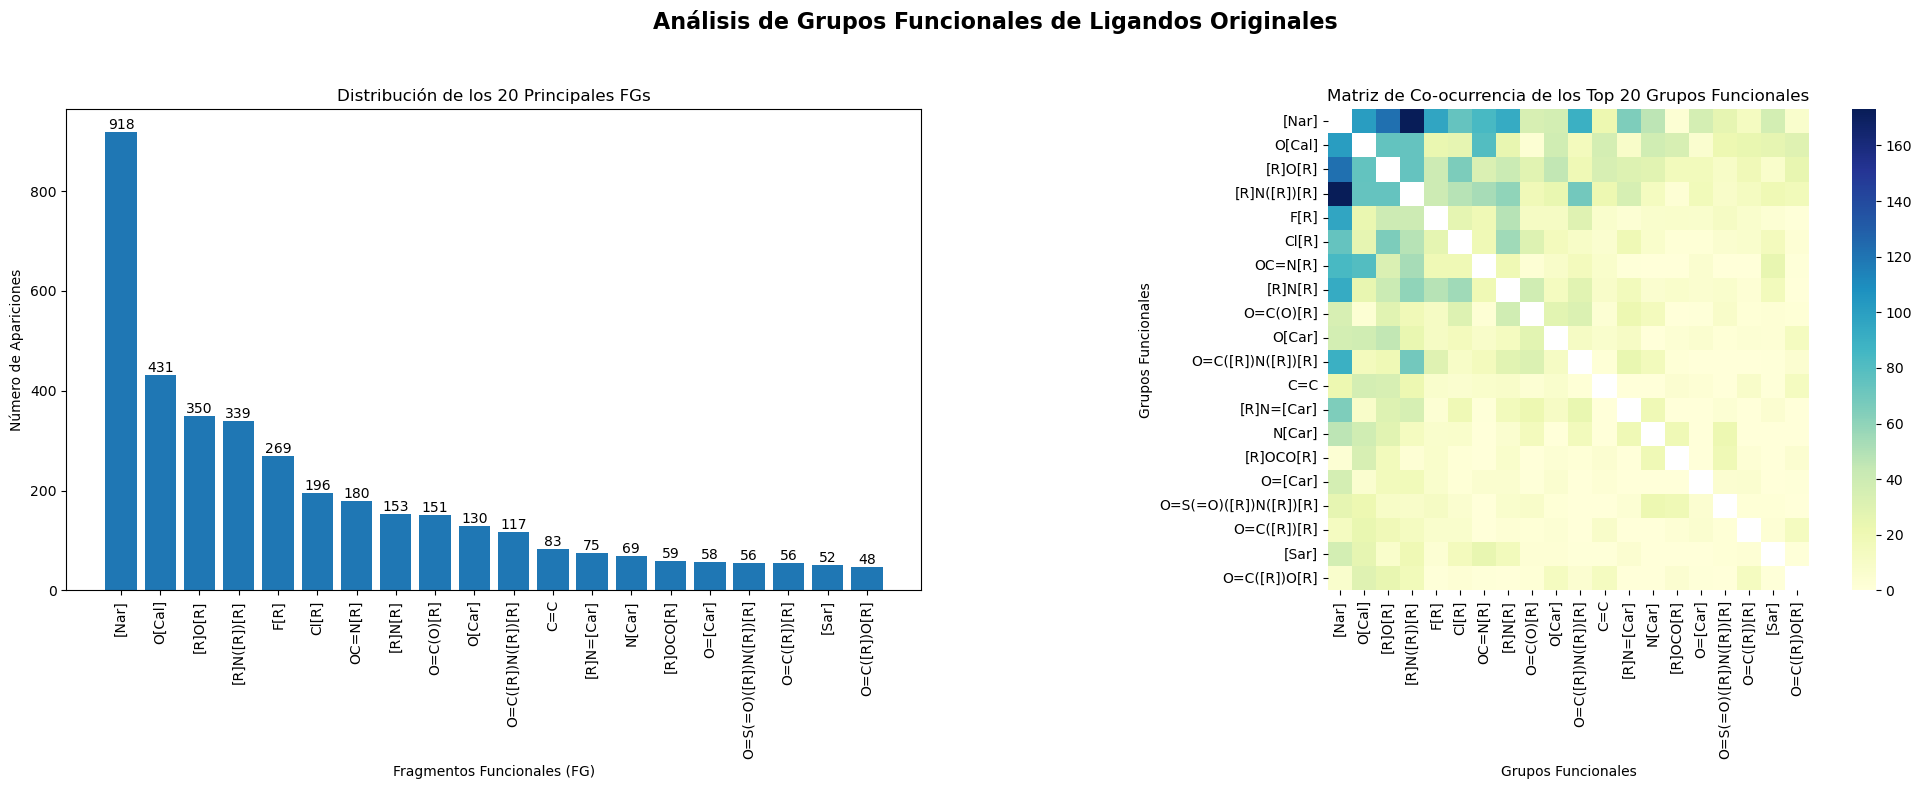

In [96]:
# Generar la figura con las dos gráficas
combinar_graficas_top_fgs(ligandos_originales, "Análisis de Grupos Funcionales de Ligandos Originales")

## Resultados con los Decoys

In [18]:
# Cargar el archivo top_100_groups.csv
top_100_groups = pd.read_csv('./data/processed/top_100_fgs_decoys.csv')

# Asegurarte de que el archivo de top 100 contiene una columna pseudo_smiles
top_smiles_list = top_100_groups['pseudo_smiles'].tolist()

# Función para convertir un vector n-hot a pseudo-smiles
def n_hot_to_pseudo_smiles(n_hot_vector, top_smiles):
    # Crear una lista para almacenar los pseudo-smiles correspondientes
    pseudo_smiles = []
    for index, count in enumerate(n_hot_vector):
        if count > 0:  # Si el grupo funcional aparece en el vector n-hot
            pseudo_smiles.extend([top_smiles[index]] * count)
    return pseudo_smiles

# Asegurarte de trabajar con una copia explícita para evitar SettingWithCopyWarning
decoys = decoys.copy()

# Convertir la columna 'n_hot_fgs' de strings a listas
decoys.loc[:, 'n_hot_fgs'] = decoys['n_hot_fgs'].apply(eval)

# Crear una nueva columna con los pseudo-smiles reconstruidos
decoys.loc[:, 'pseudo_smiles'] = decoys['n_hot_fgs'].apply(
    lambda n_hot: n_hot_to_pseudo_smiles(n_hot, top_smiles_list)
)

# Verificar si los valores son cadenas antes de aplicar eval
decoys.loc[:, 'pseudo_smiles'] = decoys['pseudo_smiles'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)
decoys.loc[:, 'n_hot_fgs'] = decoys['n_hot_fgs'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

In [75]:
# Crear identificador único si no está presente
decoys['mol_id'] = decoys.index

In [20]:
# Llamadas a la función para ligandos originales
tabla1_decoys = calcular_estadisticas_fgs(decoys)
tabla1_decoys

,n,Total FGs,FGs por mol,FGs binarios,FGs binarios por mol,FGs únicos,FGs únicos por mol
0,1428,5664,3.966387,3874,2.712885,84,0.058824


In [22]:
# Llamadas a la función calcular_estadisticas_aromaticos_heteroatomos
tabla2_decoys = calcular_estadisticas_aromaticos_heteroatomos(decoys)
tabla2_decoys

,Ar FGs (bin) / mol,# Ar FGs (un),Ar FGs (un) / mol,Het FGs (bin) / mol,# Het FGs (un),Het FGs (un) / mol
0,0.383754,764,0.535014,0.946779,3818,2.673669


In [23]:
# Llamadas a la función calcular_estadisticas_heteroatomos 
tabla3_decoys = calcular_estadisticas_heteroatomos(decoys)
tabla3_decoys

,O FGs (bin) / mol,N FGs (bin) / mol,S FGs (bin) / mol,P FGs (bin) / mol,X FGs (bin) / mol,Total O FGs,Total N FGs,Total S FGs,Total P FGs,Total X FGs
0,0.555322,0.697479,0.401961,0.0,0.329832,2068,2536,661,0,1051


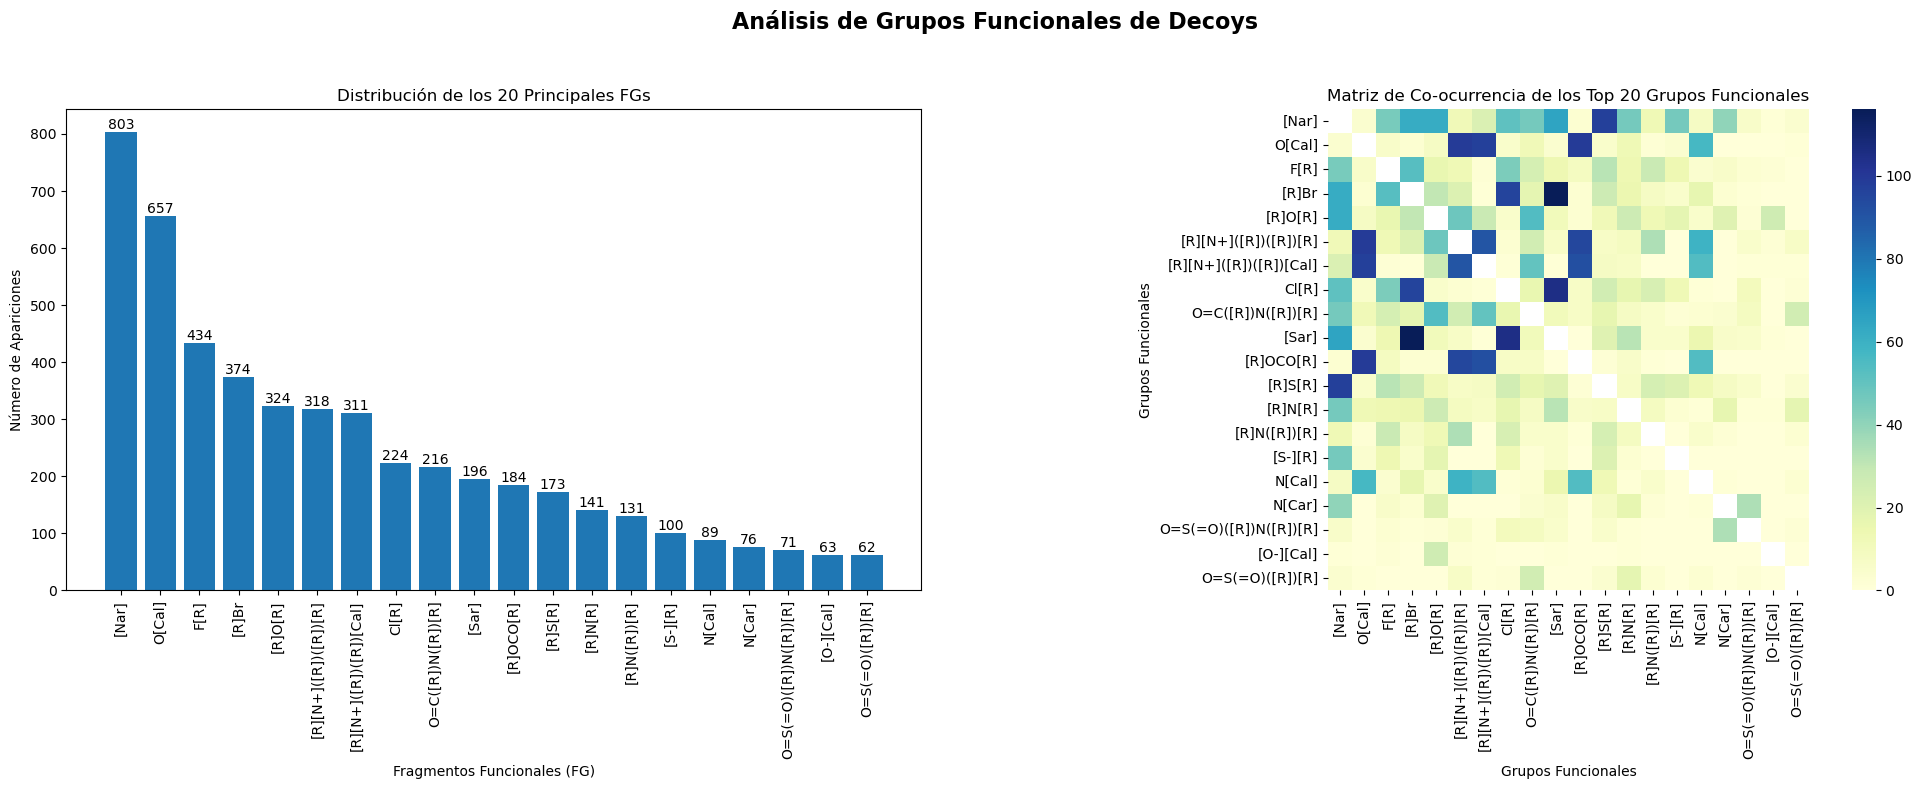

In [95]:
# Generar la figura con las dos gráficas
combinar_graficas_top_fgs(decoys, "Análisis de Grupos Funcionales de Decoys")

# Distribución Aminoácidos Sitio de Unión

In [26]:
# Definir el mapa de aminoácidos
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
amino_to_index = {aa: idx for idx, aa in enumerate(amino_acids)}

# Crear un diccionario para mapear índices a aminoácidos
index_to_amino = {idx: aa for aa, idx in amino_to_index.items()}

def one_hot_to_sequence(one_hot_vectors):
    """
    Convierte un one-hot encoding de aminoácidos a una secuencia de aminoácidos.
    """
    sequence = []
    for vector in one_hot_vectors:
        # Encuentra el índice del valor 1 en el vector
        amino_index = np.argmax(vector)
        sequence.append(index_to_amino.get(amino_index, 'X'))  # 'X' para aminoácidos desconocidos
    return ''.join(sequence)

# Aplicar la función al dataset
def add_sequence_column(df):
    """
    Agrega una columna 'Sequence' al DataFrame basada en 'One_Hot_Encoding'.
    """
    def convert_one_hot(row):
        # Verificar si la columna 'One_Hot_Encoding' es válida
        if isinstance(row, str):  # Si es una cadena, convertirla (posiblemente en formato JSON)
            one_hot_vectors = eval(row)
        elif isinstance(row, list):  # Si ya es una lista, usar directamente
            one_hot_vectors = row
        else:
            return None  # Manejo de valores no válidos
        
        return one_hot_to_sequence(one_hot_vectors)
    
    # Crear la nueva columna 'Sequence'
    df['Sequence'] = df['One_Hot_Encoding'].apply(convert_one_hot)
    return df

In [97]:
def calcular_frecuencias_aminoacidos(df):
    """
    Calcula las frecuencias de cada aminoácido en las secuencias.
    """
    all_sequences = ''.join(df['Sequence'].dropna())
    amino_acid_counts = Counter(all_sequences)
    total_residues = sum(amino_acid_counts.values())
    amino_acid_frequencies = {aa: count / total_residues for aa, count in amino_acid_counts.items()}
    return amino_acid_frequencies

def graficar_distribucion_longitudes(df):
    """
    Grafica la distribución de longitudes de las secuencias.
    """
    sns.histplot(df['Sequence_Length'], bins=20, kde=True)
    plt.title("Distribución de Longitudes de Secuencias")
    plt.xlabel("Longitud")
    plt.ylabel("Frecuencia")
    plt.show()

def graficar_frecuencias_aminoacidos(frequencies):
    """
    Grafica las frecuencias de aminoácidos.
    """
    plt.figure(figsize=(12, 6))
    plt.bar(frequencies.keys(), frequencies.values())
    plt.title("Frecuencias de Aminoácidos")
    plt.xlabel("Aminoácido")
    plt.ylabel("Frecuencia")
    plt.show()

def calcular_composicion_fisicoquimica_global(df):
    """
    Calcula la composición fisicoquímica global del dataset.
    """
    polar = set('RKHDESTNQ')
    hydrophobic = set('AILMFWVY')
    small = set('ACDGNPSTV')

    polar_count = 0
    hydrophobic_count = 0
    total_count = 0

    for sequence in df['Sequence']:
        if pd.notna(sequence):
            polar_count += sum(1 for aa in sequence if aa in polar)
            hydrophobic_count += sum(1 for aa in sequence if aa in hydrophobic)
            total_count += len(sequence)

    return {
        'Polares': polar_count / total_count if total_count > 0 else 0,
        'Hidrofóbicos': hydrophobic_count / total_count if total_count > 0 else 0
    }

def graficar_composicion_fisicoquimica_global(composition):
    """
    Genera un gráfico de queso para la composición fisicoquímica global.
    """
    labels = composition.keys()
    sizes = composition.values()

    plt.figure(figsize=(8, 8))
    plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66b3ff', '#99ff99']
    )
    plt.title("Composición Fisicoquímica Global")
    plt.axis('equal') 
    plt.show()

def graficar_top_motivos(df, k=3, top_n=20):
    """
    Grafica los motivos más comunes de longitud k en las secuencias.
    """
    def extract_motifs(sequence, k):
        return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

    # Extraer motivos de todas las secuencias
    all_motifs = []
    for seq in df['Sequence']:
        if pd.notna(seq):
            all_motifs.extend(extract_motifs(seq, k))

    # Contar los motivos más comunes
    motif_counts = Counter(all_motifs).most_common(top_n)

    # Preparar datos para graficar
    motivos, conteos = zip(*motif_counts)

    # Crear el gráfico
    plt.figure(figsize=(12, 6))
    plt.bar(motivos, conteos)
    plt.title(f"Top {top_n} Motivos Más Comunes (k={k})")
    plt.xlabel("Motivos")
    plt.ylabel("Conteo")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def mostrar_todas_las_graficas(decoys, titulo):
    """
    Genera una imagen con múltiples gráficos relacionados con las secuencias.
    Permite añadir un título general personalizado.
    """
    # Configurar la figura con subplots (2 filas x 2 columnas)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Graficar distribución de longitudes
    decoys['Sequence_Length'] = decoys['Sequence'].apply(len)
    sns.histplot(decoys['Sequence_Length'], bins=20, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title("Distribución de Longitudes de Secuencias")
    axes[0, 0].set_xlabel("Longitud")
    axes[0, 0].set_ylabel("Frecuencia")

    # 2. Graficar frecuencias de aminoácidos
    frecuencias_aminoacidos_decoys = calcular_frecuencias_aminoacidos(decoys)
    axes[0, 1].bar(frecuencias_aminoacidos_decoys.keys(), frecuencias_aminoacidos_decoys.values())
    axes[0, 1].set_title("Frecuencias de Aminoácidos")
    axes[0, 1].set_xlabel("Aminoácido")
    axes[0, 1].set_ylabel("Frecuencia")

    # 3. Graficar la composición fisicoquímica global
    composition_global_decoys = calcular_composicion_fisicoquimica_global(decoys)
    axes[1, 0].pie(
        composition_global_decoys.values(),
        labels=composition_global_decoys.keys(),
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66b3ff', '#99ff99', '#ffcc99']
    )
    axes[1, 0].set_title("Composición Fisicoquímica Global")

    # 4. Graficar los 20 motivos más comunes de longitud 3
    def extract_motifs(sequence, k):
        return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

    all_motifs = []
    for seq in decoys['Sequence']:
        if pd.notna(seq):
            all_motifs.extend(extract_motifs(seq, k=3))
    
    top_motifs = Counter(all_motifs).most_common(20)
    motivos, conteos = zip(*top_motifs)
    axes[1, 1].bar(motivos, conteos)
    axes[1, 1].set_title("Top 20 Motivos Más Comunes (k=3)")
    axes[1, 1].set_xlabel("Motivos")
    axes[1, 1].set_ylabel("Conteo")
    axes[1, 1].tick_params(axis='x', rotation=90)

    # Añadir un título general para toda la figura
    fig.suptitle(titulo, fontsize=16, fontweight='bold')

    # Ajustar el diseño para evitar superposición
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reservar espacio para el título general

    # Mostrar todas las gráficas
    plt.show()

## Resultados con Ligandos Originales

In [59]:
# Añadir columna con Secuencia
ligandos_originales = add_sequence_column(ligandos_originales)

# Calcular la longitud de las secuencias
ligandos_originales['Sequence_Length'] = ligandos_originales['Sequence'].apply(len)

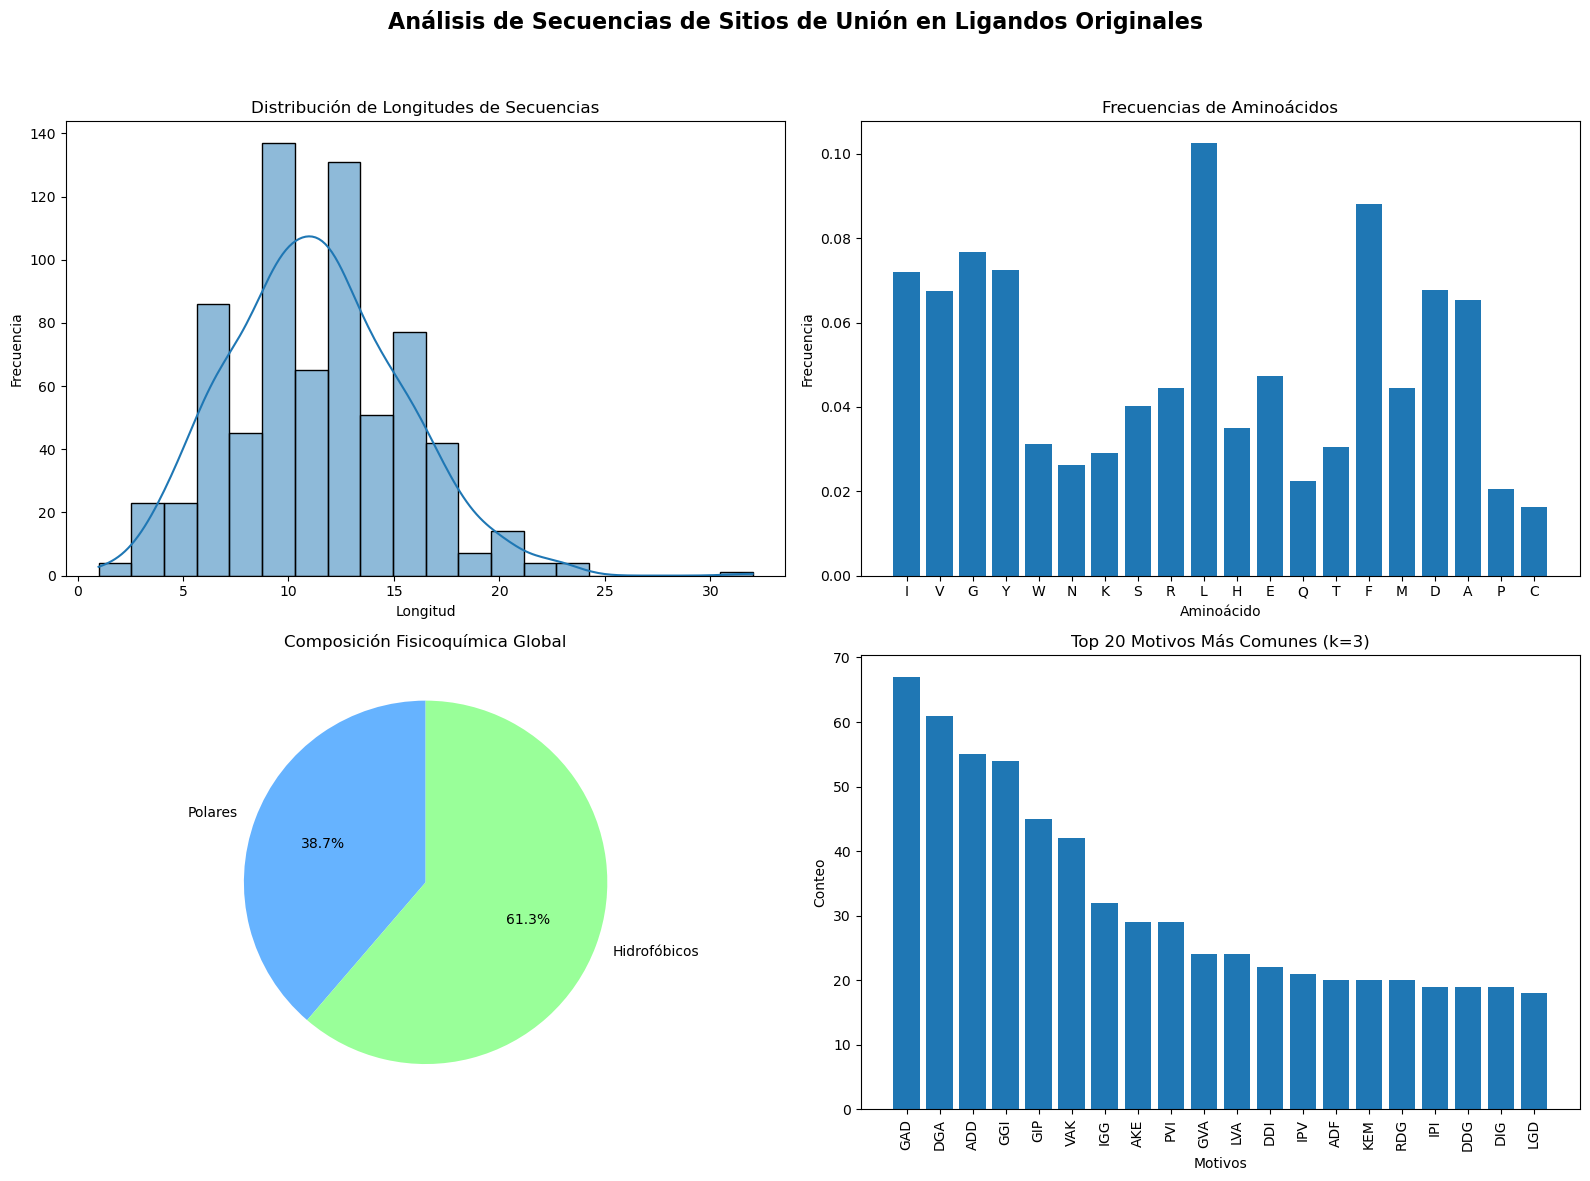

In [98]:
# Llamar a la función con el DataFrame Ligandos Originales
mostrar_todas_las_graficas(ligandos_originales, "Análisis de Secuencias de Sitios de Unión en Ligandos Originales")

## Resultados con Decoys

In [60]:
# Añadir columna con Secuencia
decoys = add_sequence_column(decoys)

# Calcular la longitud de las secuencias
decoys['Sequence_Length'] = decoys['Sequence'].apply(len)

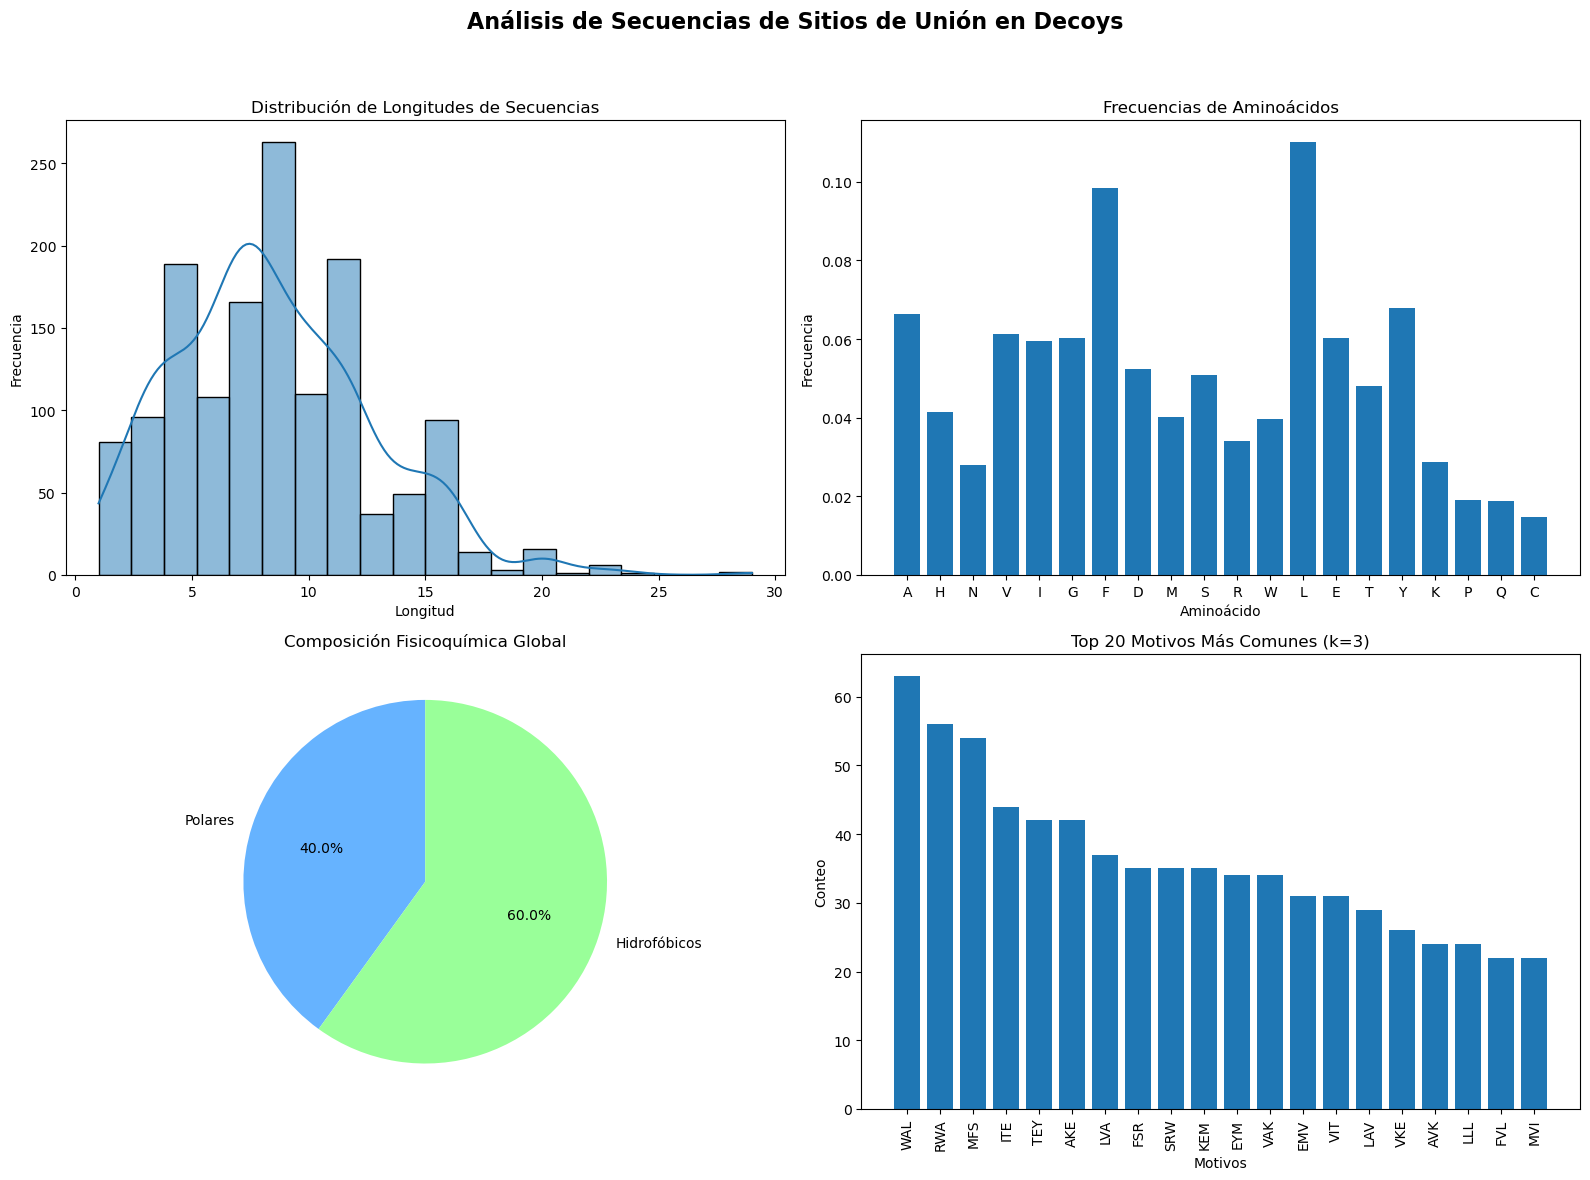

In [99]:
# Llamar a la función con el DataFrame decoys
mostrar_todas_las_graficas(decoys, "Análisis de Secuencias de Sitios de Unión en Decoys")